# Example 2 – Comparing CCN from PartMC–MOSAIC and MAM4

This example loads aerosol populations from two different models:

- **PartMC–MOSAIC** (particle-resolved)
- **MAM4** (modal aerosol scheme)

For each model, we build a `part2pop` population from example model output and
compute the **fraction of particles that activate as CCN** as a function of
supersaturation.

### What you’ll learn

- How to use `build_population` with the `"partmc"` and `"mam4"` population types.
- How to read model output from `example_data/model_output/`.
- How to generate and interpret CCN activation curves (`frac_ccn` vs supersaturation).

## Step 1 – Point to example model output

The notebook ships with a small sample of pre-computed model output under:

- `example_data/model_output/partmc`
- `example_data/model_output/mam4`

We configure `build_population` to read one time step from each dataset and construct a `Population` object representing that model’s aerosol state.

In [ ]:
from part2pop.population import build_population
from pathlib import Path
import os
import numpy as np

model_output_root = Path.cwd() / "example_data" / "model_output"

timestep = 31 # initial conditions
partmc_dir = model_output_root / "partmc"
partmc_population_cfg = {
        'type':'partmc',
        'partmc_dir': partmc_dir,
        'timestep':timestep,
        'repeat':1, # number of PartMC repeat, if run multiple times
        }

D_min = 1e-9
D_max = 1e-4
N_bins = 300 # number of bins used to analyze MAM4 output
GSDs = [1.8, 1.6, 1.6, 1.8] # geometric standard deviations for each mod
mam4_output_filename = model_output_root / "mam4" / "mam_output.nc"

mam4_population_cfg = {
            'type':'mam4',
            'mam4_dir': model_output_root / "mam4",
            'timestep':timestep,
            'GSD':GSDs, 
            'GMD_init':[1.1e-7, 2.6e-8, 2e-6, 5e-8], # initial GMDs for each mode (will be overwritten if reading from namelist) 
            "N_sigmas":5,
            'N_bins':N_bins, # number of bins to use for analysis
            'T':293.15, # temperature for analysis
            'p':101325., # pressure for analysis
                }


## Step 2 – Build `part2pop` populations

With the configuration dictionaries defined, we call `build_population` for each model.
This step converts the raw model output into a common representation that `part2pop`
can work with, including size/composition information and any required metadata.


In [ ]:
partmc_population = build_population(partmc_population_cfg)
mam4_population = build_population(mam4_population_cfg)

## Step 3 – Plot CCN activation spectra

We now compute and plot `frac_ccn`, the fraction of particles that activate as CCN,
over a range of supersaturations from 0.01% to 10%.

The x-axis is **supersaturation** (s), and the y-axis is the **fraction of CCN**.

Interpretation:

- If the curves are similar, the two models predict similar CCN activity for this case.
- Differences in the curves highlight how the two aerosol representations (particle-
  resolved vs modal) treat size/composition for CCN activation.
- You can change `timestep` above to see how the comparison evolves in time.

/Users/fier887/Library/CloudStorage/OneDrive-PNNL/Code/part2pop/src/part2pop/analysis/population/factory/Nccn.py:16: SyntaxWarning: invalid escape sequence '\m'
  short_label = '$N_{\mathrm{CCN}}(s)$',
/Users/fier887/Library/CloudStorage/OneDrive-PNNL/Code/part2pop/src/part2pop/analysis/population/factory/b_abs.py:14: SyntaxWarning: invalid escape sequence '\m'
  short_label="$b_{\mathrm{abs}}$",
/Users/fier887/Library/CloudStorage/OneDrive-PNNL/Code/part2pop/src/part2pop/analysis/population/factory/b_ext.py:14: SyntaxWarning: invalid escape sequence '\m'
  short_label="$b_{\mathrm{text}}$",
/Users/fier887/Library/CloudStorage/OneDrive-PNNL/Code/part2pop/src/part2pop/analysis/population/factory/dNdlnD_old.py:21: SyntaxWarning: invalid escape sequence '\l'
  short_label='$dN/d\ln D$',
/Users/fier887/Library/CloudStorage/OneDrive-PNNL/Code/part2pop/src/part2pop/analysis/population/factory/dNdlnD_old.py:108: SyntaxWarning: invalid escape sequence '\l'
  var.meta.short_label = "$dN/d\ln D_

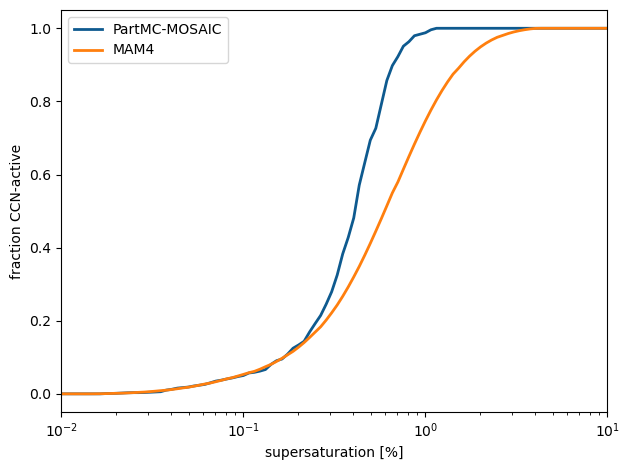

In [ ]:
from part2pop.viz.style import StyleManager, Theme
from part2pop.viz.builder import build_plotter
import matplotlib.pyplot as plt

mgr = StyleManager(Theme(), deterministic=False)

series = [
    {"key": "partmc", "population": partmc_population, "label": "PartMC-MOSAIC"},
    {"key": "mam4", "population": mam4_population, "label": "MAM4"},
]
line_styles = mgr.plan("line", [s["key"] for s in series])

fig, ax = plt.subplots()
for s in series:
    cfg = {
        "varname": "frac_ccn",
        "s_grid": np.logspace(-2,1,100),  # supersaturation grid from 0.01% to 10%
        "style": line_styles[s["key"]],
    }
    plotter = build_plotter("state_line", cfg)
    plotter.plot(s["population"], ax, label=s["label"])
ax.legend(); fig.tight_layout()